In [1]:

# https://blog.keras.io/building-autoencoders-in-keras.html

# from google.colab import drive
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pickle

from pathlib import Path

import tensorflow as tf
from keras.callbacks import ModelCheckpoint
print(tf.version.VERSION)

#import keras
%matplotlib inline



# drive.mount("/content/gdrive")

#home_path='/content/gdrive/My Drive/w251/Final_project/20200328/'
# home_path='/content/gdrive/My Drive/w251/Final_project/20200403/'

## Select tensor input

data_path = '/workspace/full_data.npy'

# ## Select weight for knowledge transfer
label_path = '/workspace/full_labels.npy'




1.13.1


Using TensorFlow backend.


In [2]:
def npy_load_data(data_path):
  imgPath = Path(data_path)
  sampleData = []
  with imgPath.open('rb') as f:
    
    fsz = os.fstat(f.fileno()).st_size
#     print(fsz)
    out = np.load(f)
    sampleData.append(out)
    while f.tell() < 15000000000:
        sampleData.append(np.load(f))
  sampleData = np.asarray(sampleData)
  print(sampleData.shape) 
  return sampleData

def npy_load_label(data_path):
  imgPath = Path(data_path)
  sampleData = []
  with imgPath.open('rb') as f:
    
    fsz = os.fstat(f.fileno()).st_size
#     print(fsz)
    out = np.load(f)
    sampleData.append(out)
    while f.tell() < fsz:
        sampleData.append(np.load(f))
  sampleData = np.asarray(sampleData)
  print(sampleData.shape) 
  return sampleData

In [3]:
data_train=npy_load_data(data_path)
data_label=npy_load_label(label_path)

data_label_sub = data_label[0:data_train.shape[0]]
data_label_sub.shape

# data_train=np.load('full_data.npy')
# data_label=np.load('full_labels.npy')
# data_label

(12330, 176, 192, 9)
(30467,)


(12330,)

In [4]:
data_label_sub.shape
data_train.shape

(12330, 176, 192, 9)

In [5]:
data_train=data_train.astype('float32')
data_label_sub = data_label_sub.astype('float32')
data_label_sub_biased=np.log(data_label_sub+30)*20

(array([4.000e+00, 3.000e+01, 1.399e+03, 7.842e+03, 2.415e+03, 4.640e+02,
        1.110e+02, 3.300e+01, 1.800e+01, 1.400e+01]),
 array([55.451775, 59.48158 , 63.511387, 67.54119 , 71.571   , 75.6008  ,
        79.63061 , 83.660416, 87.69022 , 91.720024, 95.74983 ],
       dtype=float32),
 <a list of 10 Patch objects>)

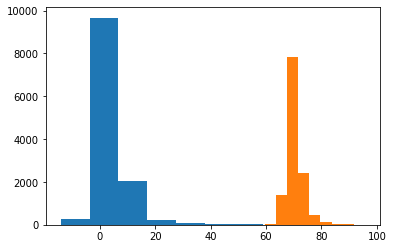

In [6]:
plt.hist(data_label_sub)
plt.hist(data_label_sub_biased)

## Split train and test data

In [7]:
data_train_in_norm=tf.keras.utils.normalize(data_train, axis = 3)

In [8]:
from sklearn.model_selection import train_test_split
# Train data normalization
xTrain, xTest, yTrain, yTest = train_test_split(data_train_in_norm, data_label_sub_biased, test_size = 0.4, random_state = 123)


## Data standarization

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
/workspace/checkpoint
Train on 7398 samples, validate on 4932 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
7398/7398 [==============================] - 102s 14ms/sample - loss: 494324.6385 - val_loss: 18.7242
Epoch 2/50
7398/7398 [==============================] - 34s 5ms/sample - loss: 466.7058 - val_loss: 16.1856
Epoch 3/50
7398/7398 [==============================] - 34s 5ms/sample - loss: 16.6861 - val_loss: 15.0032
Epoch 4/50
7398/7398 [==============================] - 34s 5ms/sample - loss: 15.4661 - val_loss: 14.4110
Epoch 5/50
7380/7398 [============================>.] - ETA: 0s - loss: 14.9078
Epoch 00005: loss improved from inf to 14.90748, saving model to /workspace/checkpoint/cp-nfl-0005.ckpt
7398/7398 [==============================] - 36s 5ms/sample - loss: 14.9075 - val_loss: 16.1010
Epoch 6/50
7398/7398 [=========================

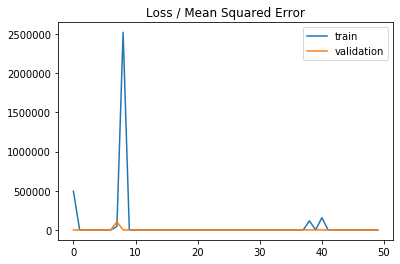

In [9]:
# Reference: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.regularizers import l1,l2

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

batch_L =30
epoch_L =50

model = Sequential()

model.add( Conv2D(32, (64, 64), kernel_regularizer=l2(0.01), activation='relu', input_shape=(176, 192, 9), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (32, 32), kernel_regularizer=l2(0.01), activation='relu', padding='same'))

model.add(Conv2D(64, (32, 32), kernel_regularizer=l2(0.01), activation='relu', padding='same'))

model.add(Conv2D(128, (32, 32), kernel_regularizer=l2(0.01), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (16, 16), kernel_regularizer=l2(0.01), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (8, 8), kernel_regularizer=l2(0.01), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(1, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='linear'))
model.add(Dense(1, kernel_regularizer=l2(0.01), activation='linear'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001)

model.compile(loss='mean_squared_error', optimizer=adam)

# checkpoint
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '/workspace/checkpoint/cp-nfl-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=5)

# Loads the weights
#initial_weight_path = '/workspace/checkpoint/cp-nfl-0100-l2-100epoch.ckpt'
initial_weight_path = '/workspace/checkpoint/cp-nfl-0050-l2_50epoch.ckpt'
model.load_weights(initial_weight_path)


# history = model.fit(xTrain, yTrain, batch_size=batch_L, epochs=epoch_L)
history = model.fit(xTrain, yTrain, batch_size=batch_L, epochs=epoch_L, 
                    callbacks=[checkpoint], validation_data=(xTest, yTest))
 

train_mse = model.evaluate(xTrain, yTrain, batch_size=batch_L)
test_mse = model.evaluate(xTest, yTest, batch_size=batch_L)

print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')




plt.legend()
plt.show()

In [10]:
# Loads the weights
initial_weight_path = '/workspace/checkpoint/cp-nfl-0025_l2_before_overfit_85epoch.ckpt'
#'cp-nfl-0025_l2_before_overfit_85epoch.ckp'
model.load_weights(initial_weight_path)

In [11]:
trainloss=history.history['loss']
valloss=history.history['val_loss']


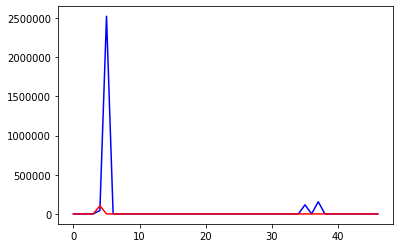

In [12]:
plt.plot(trainloss[3:],'b')
plt.plot(valloss[3:],'r')

In [1]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')


NameError: name 'plt' is not defined

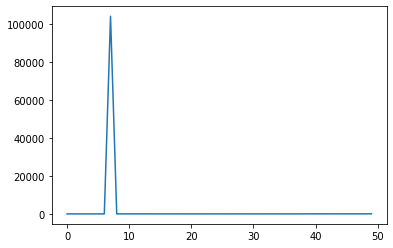

In [14]:
plt.plot(history.history['val_loss'], label='validation')

In [15]:
ynew = model.predict(xTest[0:200])


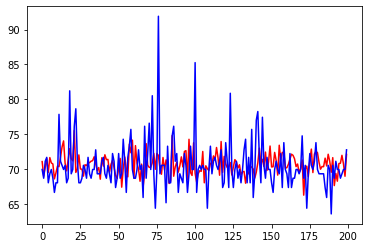

In [16]:
plt.plot(ynew[0:200],'r')
plt.plot(yTest[0:200],'b')

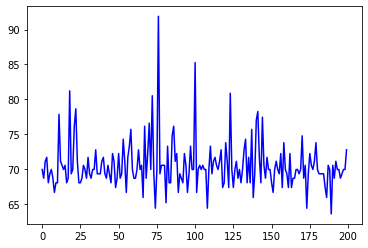

In [17]:
plt.plot(yTest[0:200],'b')

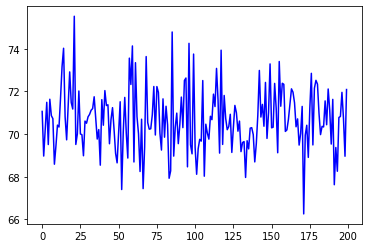

In [18]:
plt.plot(ynew[0:200],'b')

In [19]:
# Loads the weights
#checkpoint_path = '/workspace/cp-nfl-0100.ckpt'
#model.load_weights(checkpoint_path)